<a href="https://colab.research.google.com/github/SAHIL9581/LIVE-AI-CLASSES/blob/main/LIVE_AI_SECOND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install and import MIT Deep Learning utilities
!pip install mitdeeplearning > /dev/null 2>&1
import mitdeeplearning as mdl

In [ ]:
import os
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from lion_pytorch import Lion

In [ ]:
# Basic question-answer template
template_without_answer = "<start_of_turn>user\n{question}<end_of_turn>\n<start_of_turn>model\n"
template_with_answer = template_without_answer + "{answer}<end_of_turn>\n"

# Let's try to put something into the template to see how it looks
print(template_with_answer.format(question="What is your name?", answer="My name is Gemma!"))

<start_of_turn>user
What is your name?<end_of_turn>
<start_of_turn>model
My name is Gemma!<end_of_turn>



In [ ]:
# Load the tokenizer for Gemma 2B
model_id = "unsloth/gemma-2-2b-it" #"google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# How big is the tokenizer?
print(f"Vocab size: {len(tokenizer.get_vocab())}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Vocab size: 256000


In [ ]:
# Lets test out both steps:
text = "Here is some sample text!"
print(f"Original text: {text}")

# Tokenize the text
tokens = tokenizer.encode(text, return_tensors="pt")
print(f"Encoded tokens: {tokens}")

# Decode the tokens
decoded_text = tokenizer.decode(tokens[0], skip_special_tokens=True)
print(f"Decoded text: {decoded_text}")

Original text: Here is some sample text!
Encoded tokens: tensor([[     2,   4858,    603,   1009,   6453,   2793, 235341]])
Decoded text: Here is some sample text!


In [ ]:
prompt = template_without_answer.format(question="What is the capital of France? Use one word.")
print(prompt)

<start_of_turn>user
What is the capital of France? Use one word.<end_of_turn>
<start_of_turn>model



In [ ]:
# Load the model -- note that this may take a few minutes
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")

config.json:   0%|          | 0.00/913 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.23G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

In [ ]:
### Putting it together to prompt the model and generate a response ###

# 1. Construct the prompt in chat template form
question = "What is the capital of France? Use one word."
prompt = template_without_answer.format(question = question) # TODO

# 2. Tokenize the prompt
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)

# 3. Feed through the model to predict the next token probabilities
with torch.no_grad():
    output = model(tokens) # TODO

    probs = F.softmax(output.logits, dim=-1)

# 4. Get the next token, according to the maximum probability
next_token = torch.argmax(probs[0, -1, :]).item()

# 5. Decode the next token
next_token_text = tokenizer.decode([next_token]) # TODO

print(f"Prompt: {prompt}")
print(f"Predicted next token: {next_token_text}")

Prompt: <start_of_turn>user
What is the capital of France? Use one word.<end_of_turn>
<start_of_turn>model

Predicted next token: Paris


In [ ]:
prompt = template_without_answer.format(question="What does MIT stand for?")
tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.device)
output = model.generate(tokens, max_new_tokens=20)
print(tokenizer.decode(output[0]))

<bos><start_of_turn>user
What does MIT stand for?<end_of_turn>
<start_of_turn>model
MIT stands for **Massachusetts Institute of Technology**. 
<end_of_turn>


In [ ]:
train_loader, test_loader = mdl.lab3.create_dataloader(style="leprechaun")

sample = train_loader.dataset[44]
question = sample['instruction']
answer = sample['response']
answer_style = sample['response_style']

print(f"Question: {question}\n\n" +
      f"Original Answer: {answer}\n\n" +
      f"Answer Style: {answer_style}")

README.md:   0%|          | 0.00/8.20k [00:00<?, ?B/s]

databricks-dolly-15k.jsonl:   0%|          | 0.00/13.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15011 [00:00<?, ? examples/s]

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

Question: Are lilies safe for cats?

Original Answer: No, lilies are toxic to cats if consumed and should not be kept in a household with cats

Answer Style: Och, no indeed, me hearty! Them lilies there be as dangerous as a pot o' gold guarded by a banshee to a wee kitty cat! If a whiskered lad or lass takes a bite of one, it's as bad as swallowing a curse from the old Hag herself. So, ye best keep them far from yer feline friends, or else ye'll be needin' more than just a four-leaf clover to bring luck back into yer home!


In [ ]:
import torch

def chat(question, max_new_tokens=32, temperature=0.7, only_answer=False):
    # 1. Construct the prompt using the template
    prompt = template_without_answer.format(question=question)

    # 2. Tokenize the text
    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device)

    # 3. Feed through the model to predict the next token probabilities
    with torch.no_grad():
        outputs = model.generate(input_ids.input_ids, do_sample=True, max_new_tokens=max_new_tokens, temperature=temperature)

    # 4. Only return the answer if only_answer is True
    output_tokens = outputs[0]
    if only_answer:
        output_tokens = output_tokens[input_ids['input_ids'].shape[1]:]

    # 5. Decode the tokens
    result = tokenizer.decode(output_tokens, skip_special_tokens=True)

    return result


In [ ]:
# Let's try chatting with the model now to test if it works!
answer = chat(
    "What is the capital of Ireland?",
    only_answer=True,
    max_new_tokens=32,
)

print(answer)

'''TODO: Experiment with asking the model different questions and temperature values, and see how it responds!'''

The capital of Ireland is **Dublin**. 🇮🇪 



'TODO: Experiment with asking the model different questions and temperature values, and see how it responds!'

In [ ]:
# LoRA is a way to finetune LLMs very efficiently by only updating a small subset of the model's parameters

def apply_lora(model):
    # Define LoRA config
    lora_config = LoraConfig(
        r=8, # rank of the LoRA matrices
        task_type="CAUSAL_LM",
        target_modules=[
            "q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"
        ],
    )

    # Apply LoRA to the model
    lora_model = get_peft_model(model, lora_config)
    return lora_model

model = apply_lora(model)

# Print the number of trainable parameters after applying LoRA
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"number of trainable parameters: {trainable_params}")
print(f"total parameters: {total_params}")
print(f"percentage of trainable parameters: {trainable_params / total_params * 100:.2f}%")

number of trainable parameters: 10383360
total parameters: 2624725248
percentage of trainable parameters: 0.40%


In [ ]:
def forward_and_compute_loss(model, tokens, mask, context_length=512):
    # Truncate to context length
    tokens = tokens[:, :context_length]
    mask = mask[:, :context_length]

    # Construct the input, output, and mask
    x = tokens[:, :-1]
    y = tokens[:, 1:]
    mask = mask[:, 1:]

    # Forward pass to compute logits
    logits = model(x).logits

    # Compute loss
    loss = F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        y.view(-1),
        reduction="none"
    )

    # Mask out the loss for non-answer tokens
    loss = loss[mask.view(-1)].mean()

    return loss

In [ ]:
!pip install lion-pytorch

import torch
from peft import LoraConfig, get_peft_model
from lion_pytorch import Lion  # ✅ Correct

from torch.utils.data import DataLoader, Dataset

# Example dataset (Replace this with your actual data)
data = [
    {"instruction": "What is the capital of France?", "response_style": "Paris"},
    {"instruction": "Who wrote Hamlet?", "response_style": "William Shakespeare"},
]

class CustomDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "instruction": item["instruction"],
            "response_style": item["response_style"]
        }


def train(model, dataloader, tokenizer, max_steps=200, context_length=512, learning_rate=1e-4):
    losses = []

    # Apply LoRA to the model
    lora_config = LoraConfig(
        r=8,
        task_type="CAUSAL_LM",
        target_modules=[
            "q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"
        ],
    )
    model = get_peft_model(model, lora_config)

    optimizer = Lion(model.parameters(), lr=learning_rate)

    # Training loop
    for step, batch in enumerate(dataloader):
        print(batch)  # Debugging: Check batch structure

        question = batch.get("instruction", [""])[0]
        answer = batch.get("response_style", [""])[0]

        # Format text using template
        text = template_with_answer.format(question=question, answer=answer)

        # Tokenize text
        ids = tokenizer(text, return_tensors="pt", return_offsets_mapping=True).to(model.device)
        mask = ids["offset_mapping"][:, :, 0] >= text.index(answer)

        # Compute loss
        loss = forward_and_compute_loss(model, ids["input_ids"], mask, context_length=context_length) #mask was missing here

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Monitor progress
        if step % 10 == 0:
            print(chat("What is the capital of France?", only_answer=True))
            print(f"Step {step} Loss: {torch.mean(torch.tensor(losses)).item()}")
            losses = []

        if step > 0 and step % max_steps == 0:
            break

    return model

# Create an instance of the CustomDataset
train_dataset = CustomDataset(data, tokenizer)

# Create a DataLoader from the dataset
dataloader = DataLoader(train_dataset, batch_size=1) # Create dataloader here

# Call the train function to fine-tune the model! Hint: you'll start to see results after a few dozen steps.
model = train(model, dataloader, tokenizer, max_steps=200, context_length=512, learning_rate=1e-4) # TODO
print(model)


{'instruction': ['What is the capital of France?'], 'response_style': ['Paris']}
The capital of France is **Paris**. 🇫🇷 

Step 0 Loss: 11.689175605773926
{'instruction': ['Who wrote Hamlet?'], 'response_style': ['William Shakespeare']}
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): Gemma2ForCausalLM(
          (model): Gemma2Model(
            (embed_tokens): Embedding(256000, 2304, padding_idx=0)
            (layers): ModuleList(
              (0-25): 26 x Gemma2DecoderLayer(
                (self_attn): Gemma2Attention(
                  (q_proj): lora.Linear(
                    (base_layer): Linear(in_features=2304, out_features=2048, bias=False)
                    (lora_dropout): ModuleDict(
                      (default): Identity()
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=2304, out_features=8, bias=False)
              

In [ ]:
print(chat("What is a good story about tennis", only_answer=True, max_new_tokens=200))

## The Outsider's Gambit 

The air crackled with tension, thicker than the humidity clinging to the court. A hush fell over the crowd as Elena, the young prodigy, served. Her opponent, a seasoned veteran known only as "The Shadow," returned the serve with an almost bored grace, a sly smile playing on his lips.

Elena's game was a whirlwind of power and precision. A fierce competitor, she had been dominating the junior circuit, her name whispered in awe by seasoned players. But The Shadow, with his years of experience and a seemingly unflappable demeanor, was a different beast. He wasn't just a player; he was a legend, a myth whispered in hushed tones on the sidelines. 

Their match was a battleground of wills. Elena's aggressive forehand was met with The Shadow's unwavering defense. Every point was a struggle, a dance of skill and strategy, each exchange a testament to their individual mastery. The crowd,


In [ ]:
# Load the Yoda-speak dataset and fine-tune the model using your training function
train_loader, test_loader = mdl.lab3.create_dataloader(style="yoda")
model = train(model, dataloader, tokenizer, max_steps=200, context_length=512, learning_rate=1e-4) # TODO

Map:   0%|          | 0/2048 [00:00<?, ? examples/s]

{'instruction': ['What is the capital of France?'], 'response_style': ['Paris']}
The capital of France is **Paris**. 🇫🇷 

Step 0 Loss: 11.689175605773926
{'instruction': ['Who wrote Hamlet?'], 'response_style': ['William Shakespeare']}


In [11]:
### LLM as a judge ###

"""
TODO: Experiment with different system prompts to see how they affect the judge LLM's evaluation!
      Come back to this cell after you've generated some text from your model.
"""

system_prompt = """
You are an impartial judge that evaluates if text was written by {style}.

An example piece of text from {style} is:
{example}

Now, analyze some new text carefully and respond on if it follows the
same style of {style}. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of {style}, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of {style}.

The format of your response should be a JSON dictionary and nothing else:
{{"score": <score between 0 and 10>}}
"""

# ✅ Ensure `style` and `example` are properly defined before formatting
style = "Yoda"
example = """
The very Republic is threatened, if involved the Sith are.
Hard to see, the dark side is.
Discover who this assassin is, we must.
With this Naboo queen you must stay, Qui-Gon. Protect her.
May the Force be with you.
A vergence, you say? But you do! Revealed your opinion is.
Trained as a Jedi, you request for him? Good, good, young one.
""".strip()  # ✅ Removed unwanted leading/trailing whitespace

# ✅ Format the prompt
if style and example:
    system_prompt = system_prompt.format(style=style, example=example).strip()  # ✅ Remove excess whitespace

print("=== System prompt ===")
print(system_prompt)


=== System prompt ===
You are an impartial judge that evaluates if text was written by Yoda.

An example piece of text from Yoda is:
The very Republic is threatened, if involved the Sith are. 
Hard to see, the dark side is. 
Discover who this assassin is, we must. 
With this Naboo queen you must stay, Qui-Gon. Protect her. 
May the Force be with you. 
A vergence, you say? But you do! Revealed your opinion is. 
Trained as a Jedi, you request for him? Good, good, young one.

Now, analyze some new text carefully and respond on if it follows the
same style of Yoda. Be critical to identify any issues in the text.
Then convert your feedback into a number between 0 and 10: 10 if the text
is written exactly in the style of Yoda, 5 if mixed faithfulness to the
style, or 0 if the text is not at all written in the style of Yoda.

The format of your response should be a JSON dictionary and nothing else:
{"score": <score between 0 and 10>}


In [12]:
OPENROUTER_API_KEY = "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" # TODO: add your OpenRouter API key here
assert OPENROUTER_API_KEY != "", "You must set your OpenRouter API key before running this cell!"

model_name = "liquid/lfm-40b"
# model_name = "google/gemma-2-9b-it"
llm = mdl.lab3.LLMClient(model=model_name, api_key=OPENROUTER_API_KEY)

In [13]:
import json
from opik.evaluation.metrics import base_metric, score_result

class LLMJudgeEvaluator(base_metric.BaseMetric):
    def __init__(self, judge: mdl.lab3.LLMClient = None, system_prompt: str = None):
        self.judge = judge
        self.system_prompt = system_prompt
        self.prompt_template = "Evaluate this text: {text}"  # ✅ Template for input text

    def score(self, text: str, n_tries=20, **kwargs):
        """ Evaluate by asking an LLM to score it. """

        for attempt in range(n_tries):
            try:
                # ✅ Convert the text to the required format before passing it to the judge LLM
                prompt = self.prompt_template.format(text=text)

                # ✅ Stop generation when LLM outputs "}"
                stop = ["}"]

                # ✅ Call the judge LLM with the system prompt and formatted user prompt
                res = self.judge.ask(
                    system=self.system_prompt,  # ✅ Pass the system prompt
                    user=prompt,  # ✅ Formatted user prompt
                    max_tokens=50,  # ✅ Reasonable token limit to avoid excessive generation
                    stop=stop  # ✅ Stop after generating "}"
                )

                # ✅ Extract the assistant's response and ensure valid JSON format
                res_text = res.choices[0].message.content.strip() + "}"
                res_dict = json.loads(res_text)  # Convert response to JSON

                max_score = 10  # ✅ The maximum expected score from the LLM
                score = res_dict["score"] / max_score  # Normalize score
                score = max(0.0, min(score, 1.0))  # ✅ Clip score between 0 and 1

                # ✅ Return the score result
                return score_result.ScoreResult(name="StyleScore", value=score)

            except Exception as e:
                if attempt == n_tries - 1:  # ✅ If last attempt, raise the error
                    raise e
                continue  # ✅ Retry if not the last attempt


In [14]:
judge = LLMJudgeEvaluator(llm, system_prompt=system_prompt)

In [15]:
def scoring_function(text):
    return judge.score(text).value

test_texts = [
    "Tennis is a fun sport. But you must concentrate.",
    "Fun sport, tennis is. But work hard, you must.",
    "Hard to see, the dark side is."
]

for text in test_texts:
    score = scoring_function(text)
    print(f"{text} ==> Score: {score}")

Tennis is a fun sport. But you must concentrate. ==> Score: 0.5
Fun sport, tennis is. But work hard, you must. ==> Score: 0.0
Hard to see, the dark side is. ==> Score: 1.0


In [19]:
import torch
from tqdm import tqdm

# Generate text from your model by asking it new questions.
def generate_samples_from_test(test_loader, num_samples, model):
    samples = []
    for test_sample in tqdm(test_loader, total=num_samples):
        test_question = test_sample['instruction'][0]
        with torch.no_grad():
            # ✅ Replace 'chat' with 'model.ask' (or the correct method for your model)
            generated = model.ask(user=test_question, max_tokens=100).choices[0].message.content.strip()
        samples.append(generated)
        if len(samples) >= num_samples:
            break
    return samples

# Make sure 'model' is correctly defined before calling the function
n_samples = 20
generated_samples = generate_samples_from_test(test_loader, num_samples=n_samples, model=llm)  # ✅ Ensure 'llm' is defined


 95%|█████████▌| 19/20 [00:29<00:01,  1.56s/it]


In [20]:
base_samples = [sample['response'][0] for i, sample in enumerate(train_loader) if i < n_samples]
style_samples = [sample['response_style'][0] for i, sample in enumerate(train_loader) if i < n_samples]

In [21]:
# Create a multiprocessed scoring function to score the samples in parallel

os.environ["TOKENIZERS_PARALLELISM"] = "false"
from multiprocessing import Pool

def compute_scores_in_parallel(samples):
    with Pool(processes=10) as pool:
        scores = pool.map(scoring_function, samples)
    return scores

# Compute and print the scores for the base-style text, generated text, and training-set text in Yoda-speak style
base_scores = compute_scores_in_parallel(base_samples)
print(f"Base: {np.mean(base_scores):.2f} ± {np.std(base_scores):.2f}")

generated_scores = compute_scores_in_parallel(generated_samples)
print(f"Gen: {np.mean(generated_scores):.2f} ± {np.std(generated_scores):.2f}")

style_scores = compute_scores_in_parallel(style_samples)
print(f"Train: {np.mean(style_scores):.2f} ± {np.std(style_scores):.2f}")

Base: 0.04 ± 0.10
Gen: 0.11 ± 0.23
Train: 0.37 ± 0.24


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


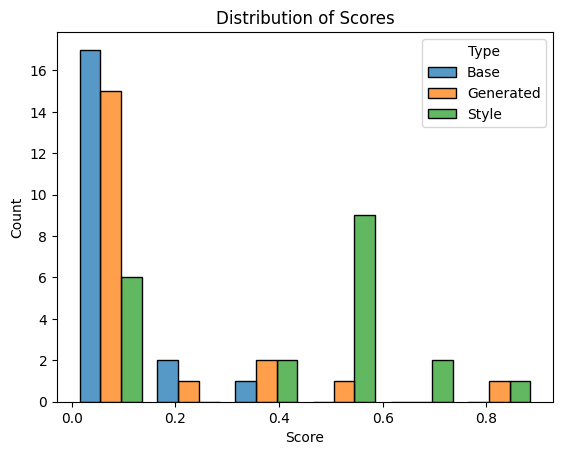

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt # Import matplotlib.pyplot

# Create clean DataFrame
df = pd.DataFrame({
    'Score': [*base_scores, *generated_scores, *style_scores],
    'Type': ['Base']*len(base_scores) + ['Generated']*len(generated_scores) + ['Style']*len(style_scores)
})

# Plot with seaborn
sns.histplot(data=df, x='Score', hue='Type', multiple="dodge", bins=6, shrink=.8)

plt.title('Distribution of Scores')
plt.show()

In [1]:
# DO NOT CHANGE/MODIFY THIS CELL.
# EXECUTE IT BEFORE SUBMITTING YOUR ENTRY TO THE LAB.
import torch
import mitdeeplearning as mdl  # Import the module before using it
from transformers import AutoTokenizer, AutoModelForCausalLM  # Import AutoModelForCausalLM
import torch.nn.functional as F  # Import and alias functional as
yoda_test_text = mdl.lab3.yoda_test_text

# Load the tokenizer for Gemma 2B (same model_id as before)
model_id = "unsloth/gemma-2-2b-it"  # Or your model_id
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the model
model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto") # Load the model here

tokens = tokenizer(yoda_test_text, return_tensors="pt").to(model.device)

# Get the loglikelihood from the model
with torch.no_grad():
    outputs = model(**tokens)
    logits = outputs.logits[:, :-1]
    targets = tokens.input_ids[:, 1:]
    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)),
                            targets.reshape(-1))

print(f"Yoda test loglikelihood: {loss.item():.2f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Yoda test loglikelihood: 3.16
